# GARCH Volatility Forecast

[*********************100%%**********************]  1 of 1 completed
/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_92783/1868339990.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_forecast[t] = omega + alpha * residuals[t-1]**2 + beta * var_forecast[t-1]
/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_92783/1868339990.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conditional_volatility[t] = omega_mle + alpha_mle * residuals[t-1]**2 + beta_mle * conditional_volatility[t-1]


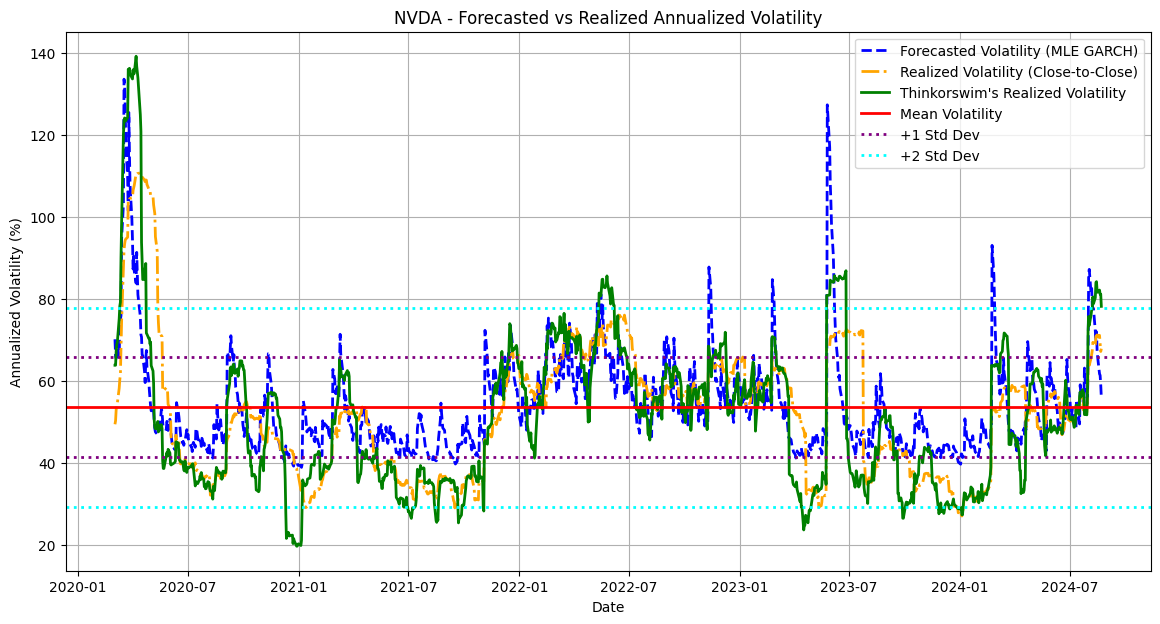

/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_92783/1868339990.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_volatility[t] = omega_mle + alpha_mle * residuals[-1]**2 + beta_mle * last_volatility


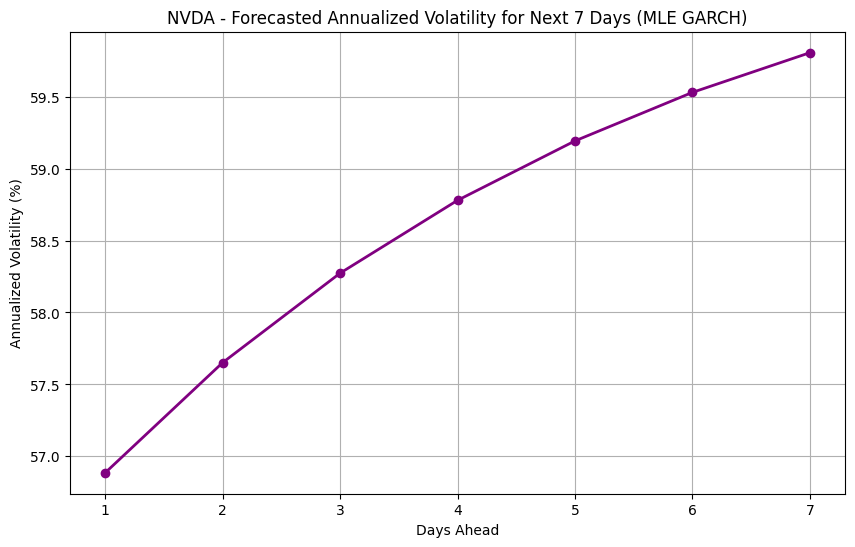

In [77]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as spop

# 1. Data Preparation
stock_symbol = 'NVDA'
start_date = '2020-01-01'
end_date = '2024-08-23'
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate close-to-close returns
returns = 100 * stock_data['Close'].pct_change().dropna()

# Calculate realized volatility using close-to-close returns
def close_to_close_volatility(returns, window=40):
    return returns.rolling(window=window).std()

# Calculate realized volatility over the entire period
realized_volatility_cc = close_to_close_volatility(returns, window=40)

# Annualize the realized volatility
trading_days_per_year = 252
realized_annualized_volatility_cc = realized_volatility_cc * np.sqrt(trading_days_per_year)

# Drop NaN values from the realized volatility
realized_annualized_volatility_cc = realized_annualized_volatility_cc.dropna()

# Calculate Thinkorswim's realized volatility (typically using a 21-day window)
def calculate_thinkorswim_volatility(prices, window=21):
    returns = prices.pct_change().dropna()
    log_returns = np.log(1 + returns)
    volatility = log_returns.rolling(window=window).std() * np.sqrt(252) * 100
    return volatility

# Calculate Thinkorswim's realized volatility over the entire period
thinkorswim_realized_volatility = calculate_thinkorswim_volatility(stock_data['Close'])

# Drop NaN values from Thinkorswim's realized volatility
thinkorswim_realized_volatility = thinkorswim_realized_volatility.dropna()

# GARCH(1, 1) Log-Likelihood Function
def garch_mle(params):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    
    residuals = returns - mu
    var_forecast = np.zeros_like(residuals)
    var_forecast[0] = np.var(residuals)
    
    for t in range(1, len(residuals)):
        var_forecast[t] = omega + alpha * residuals[t-1]**2 + beta * var_forecast[t-1]
    
    log_likelihood = -0.5 * (np.log(2 * np.pi) + np.log(var_forecast) + residuals**2 / var_forecast)
    
    return -np.sum(log_likelihood)

# Initial parameters: [mu, omega, alpha, beta]
initial_params = [np.mean(returns), 0.1, 0.1, 0.8]

# Optimize the log-likelihood function
opt_params = spop.minimize(garch_mle, initial_params, method='Nelder-Mead')
mu_mle, omega_mle, alpha_mle, beta_mle = opt_params.x

# Calculate the conditional volatility using the estimated parameters
residuals = returns - mu_mle
conditional_volatility = np.zeros_like(residuals)
conditional_volatility[0] = np.var(residuals)

for t in range(1, len(residuals)):
    conditional_volatility[t] = omega_mle + alpha_mle * residuals[t-1]**2 + beta_mle * conditional_volatility[t-1]

# Annualize the conditional volatility
conditional_volatility_annualized = np.sqrt(conditional_volatility) * np.sqrt(trading_days_per_year)

# Calculate mean and standard deviations of the conditional volatility
mean_volatility = np.mean(conditional_volatility_annualized)
std_volatility = np.std(conditional_volatility_annualized)

# Calculate the bands
volatility_plus_1std = mean_volatility + std_volatility
volatility_plus_2std = mean_volatility + 2 * std_volatility
volatility_minus_1std = mean_volatility - std_volatility
volatility_minus_2std = mean_volatility - 2 * std_volatility

# Align the lengths of forecasted, realized, and Thinkorswim's volatilities
min_length = min(len(conditional_volatility_annualized), len(realized_annualized_volatility_cc), len(thinkorswim_realized_volatility))
conditional_volatility_trimmed = conditional_volatility_annualized[-min_length:]
realized_volatility_cc_trimmed = realized_annualized_volatility_cc[-min_length:]
thinkorswim_volatility_trimmed = thinkorswim_realized_volatility[-min_length:]

# Plotting the Comparison of Volatilities from start_date to end_date
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[-min_length:], conditional_volatility_trimmed, label='Forecasted Volatility (MLE GARCH)', 
          color='blue', linewidth=2, linestyle='--')
plt.plot(stock_data.index[-min_length:], realized_volatility_cc_trimmed.values, label='Realized Volatility (Close-to-Close)', 
          color='orange', linewidth=2, linestyle='-.')
plt.plot(stock_data.index[-min_length:], thinkorswim_volatility_trimmed.values, label="Thinkorswim's Realized Volatility", 
          color='green', linewidth=2, linestyle='-')

# Plotting the mean and standard deviation bands
plt.axhline(mean_volatility, color='red', linewidth=2, linestyle='-', label='Mean Volatility')
plt.axhline(volatility_plus_1std, color='purple', linewidth=2, linestyle=':', label='+1 Std Dev')
plt.axhline(volatility_minus_1std, color='purple', linewidth=2, linestyle=':')
plt.axhline(volatility_plus_2std, color='cyan', linewidth=2, linestyle=':', label='+2 Std Dev')
plt.axhline(volatility_minus_2std, color='cyan', linewidth=2, linestyle=':')

plt.title(f'{stock_symbol} - Forecasted vs Realized Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.grid(True)  # Adding grid for better readability
plt.show()

# Set the forecast horizon (number of days ahead)
forecast_horizon = 7  # Adjust this to your desired forecast horizon

# Forecast the next 'forecast_horizon' days of volatility using the MLE GARCH model
forecasted_volatility = np.zeros(forecast_horizon)
last_volatility = conditional_volatility[-1]

for t in range(forecast_horizon):
    forecasted_volatility[t] = omega_mle + alpha_mle * residuals[-1]**2 + beta_mle * last_volatility
    last_volatility = forecasted_volatility[t]

# Annualize the forecasted volatilities
forecasted_volatility_annualized = np.sqrt(forecasted_volatility) * np.sqrt(trading_days_per_year)

# Plotting the Forecasted Volatility for the Next 7 Days
plt.figure(figsize=(10, 6))
plt.plot(range(1, forecast_horizon + 1), forecasted_volatility_annualized, marker='o', color='purple', linewidth=2, linestyle='-')
plt.title(f'{stock_symbol} - Forecasted Annualized Volatility for Next {forecast_horizon} Days (MLE GARCH)')
plt.xlabel('Days Ahead')
plt.ylabel('Annualized Volatility (%)')
plt.grid(True)  # Adding grid for better readability
plt.show()


# Volatility Cone Analysis

[*********************100%%**********************]  1 of 1 completed


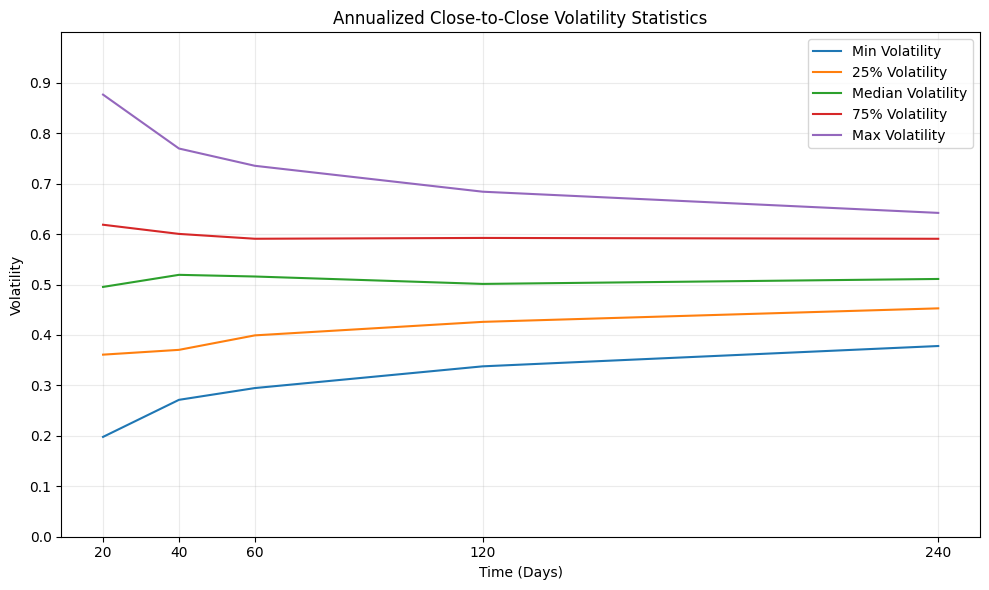

In [78]:
# Function to calculate historical volatility
def calculate_historical_vols(df, sessions_in_year):
    # Calculate first log returns using the open
    log_returns = []
    log_returns.append(np.log(df.iloc[0]['Close'] / df.iloc[0]['Open']))
    
    # Calculate all but first log returns using close to close
    for index in range(len(df) - 1):
        log_returns.append(np.log(df.iloc[index + 1]['Close'] / df.iloc[index]['Close']))
    df = df.assign(log_returns=log_returns)

    # Define periods for volatility calculation
    periods = [20, 40, 60, 120, 240]
    for period in periods:
        if len(df) > period - 1:
            sd_list, vol_list = [], []
            for index in range(period - 1):
                sd_list.append(np.nan)
                vol_list.append(np.nan)
            for index in range(len(df) - period + 1):
                sd = np.std(df.iloc[index:index + period]['log_returns'], ddof=1)
                sd_list.append(sd)
                vol_list.append(sd * np.sqrt(sessions_in_year))
            df = df.assign(**{f'sd_{period}_day': sd_list})
            df = df.assign(**{f'vol_{period}_day': vol_list})

    return df

# Parameters
sessions_in_year = 252  # Assuming the stock market is open ~252 days/year
ticker = 'NVDA'  
start_date = '2020-08-21'
end_date = '2024-08-21'

# Fetch historical stock data using yfinance
df = yf.download(ticker, start=start_date, end=end_date)
df['Date'] = df.index  # Use index as Date column
df = calculate_historical_vols(df, sessions_in_year)

# Calculate the required statistics for each period
volatility_stats = {}
periods = [20, 40, 60, 120, 240]
for period in periods:
    vol_data = df[f'vol_{period}_day'].dropna()
    volatility_stats[period] = {
        'min': vol_data.min(),
        '25%': vol_data.quantile(0.25),
        'median': vol_data.median(),
        '75%': vol_data.quantile(0.75),
        'max': vol_data.max()
    }

# Plot the volatility statistics
plt.figure(figsize=(10, 6))

# Plot lines for each statistic
for stat in ['min', '25%', 'median', '75%', 'max']:
    plt.plot(periods, [volatility_stats[period][stat] for period in periods], label=f'{stat.capitalize()} Volatility')

plt.xlabel('Time (Days)')
plt.ylabel('Volatility')
plt.title('Annualized Close-to-Close Volatility Statistics')
plt.xticks([20, 40, 60, 120, 240])
plt.yticks(np.arange(0, 1.0, 0.1))
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()